# FINAL Meteo 203 Lab Exercise
## Investigating the Onset of the 1997–1998 El Niño: A Zonal Wind and SST Anomaly Analysis  
---

First: Libraries are imported. This is to remove redundancies later on when importing packages. <br>
The data is also imported and displayed, to ensure the data is complete.

In [24]:

# Importing libraries
import xeofs as xe
import xarray as xr
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box

# Loading dataset
file_path = '..\..\data\era5_world.nc'
data = xr.open_dataset(file_path)

# Display dataset information
data

<xarray.Dataset> Size: 9GB
Dimensions:     (valid_time: 1030, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2025-10-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 16kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 4GB ...
    sst         (valid_time, latitude, longitude) float32 4GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-27T10:28 GRIB to CDM+CF via cfgrib-0.9.1...

---

Data is clipped to focus on the Pacific. The data is also grouped and averaged by season, each season being 3 months long. 
<br>
These will be the means that will be used in computing the anomaly later on.
According to [NCEI NOAA](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni), climatological anomalies are computed relative to a base period of 30 years. So for this exercise, the climatological mean is computed from the year 1981 to 2010.

<br>
Data is clipped using the slice() function (as used in exer 06 and 07).

The data for seasons is extracted as shown on the code block, as opposed to the method used in exer 07, which was:
<br>
```season = ds.sel(month=[x,y,z]).mean("month")```
<br><br>
This is because the time dimension for our particular dataset is just valid_time. 
<br>
There are no available metadata that separates the data into ```Year, Month, Day```.


In [25]:
# Clipping the data 
data_pacific = data.sel(valid_time=slice("1981", "2010"), longitude=slice(120, 280), latitude=slice(30, -30))

# Separating seasons and computing climatological means
JFM = data_pacific.sel(valid_time = data_pacific.valid_time.dt.month.isin([1,2,3])).mean(dim="valid_time")
AMJ = data_pacific.sel(valid_time = data_pacific.valid_time.dt.month.isin([4,5,6])).mean(dim="valid_time")
JAS = data_pacific.sel(valid_time = data_pacific.valid_time.dt.month.isin([7,8,9])).mean(dim="valid_time")
OND = data_pacific.sel(valid_time = data_pacific.valid_time.dt.month.isin([10,11,12])).mean(dim="valid_time")

data_pacific 

<xarray.Dataset> Size: 445MB
Dimensions:     (valid_time: 360, latitude: 241, longitude: 641)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 1981-01-01 ... 2010-12-01
  * latitude    (latitude) float64 2kB 30.0 29.75 29.5 ... -29.5 -29.75 -30.0
  * longitude   (longitude) float64 5kB 120.0 120.2 120.5 ... 279.5 279.8 280.0
    expver      (valid_time) <U4 6kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 222MB ...
    sst         (valid_time, latitude, longitude) float32 222MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-27T10:28 GRIB to CDM+CF via cfgrib-0.9.1...

---

Computing 1997 mean for each season by first isolating the target year, then grouping into months, similar to the method used in the previous code block.


In [26]:
data_1997 = data.sel(valid_time="1997", longitude=slice(120, 280), latitude=slice(30, -30))

# Separating seasons and computing climatological means
JFM_1997 = data_1997.sel(valid_time = data_1997.valid_time.dt.month.isin([1,2,3])).mean(dim="valid_time")
AMJ_1997 = data_1997.sel(valid_time = data_1997.valid_time.dt.month.isin([4,5,6])).mean(dim="valid_time")
JAS_1997 = data_1997.sel(valid_time = data_1997.valid_time.dt.month.isin([7,8,9])).mean(dim="valid_time")
OND_1997 = data_1997.sel(valid_time = data_1997.valid_time.dt.month.isin([10,11,12])).mean(dim="valid_time")

In [27]:
JFM_1997

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 241, longitude: 641)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 2kB 30.0 29.75 29.5 ... -29.5 -29.75 -30.0
  * longitude  (longitude) float64 5kB 120.0 120.2 120.5 ... 279.5 279.8 280.0
Data variables:
    u10        (latitude, longitude) float32 618kB -0.5554 -0.5554 ... -2.03
    sst        (latitude, longitude) float32 618kB nan nan nan ... 294.1 294.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-27T10:28 GRIB to CDM+CF via cfgrib-0.9.1...

---
Computing for the anomalies and plotting them into subplots.
---

In [28]:
JFM_anom = JFM_1997 - JFM
AMJ_anom = AMJ_1997 - AMJ
JAS_anom = JAS_1997 - JAS
OND_anom = OND_1997 - OND

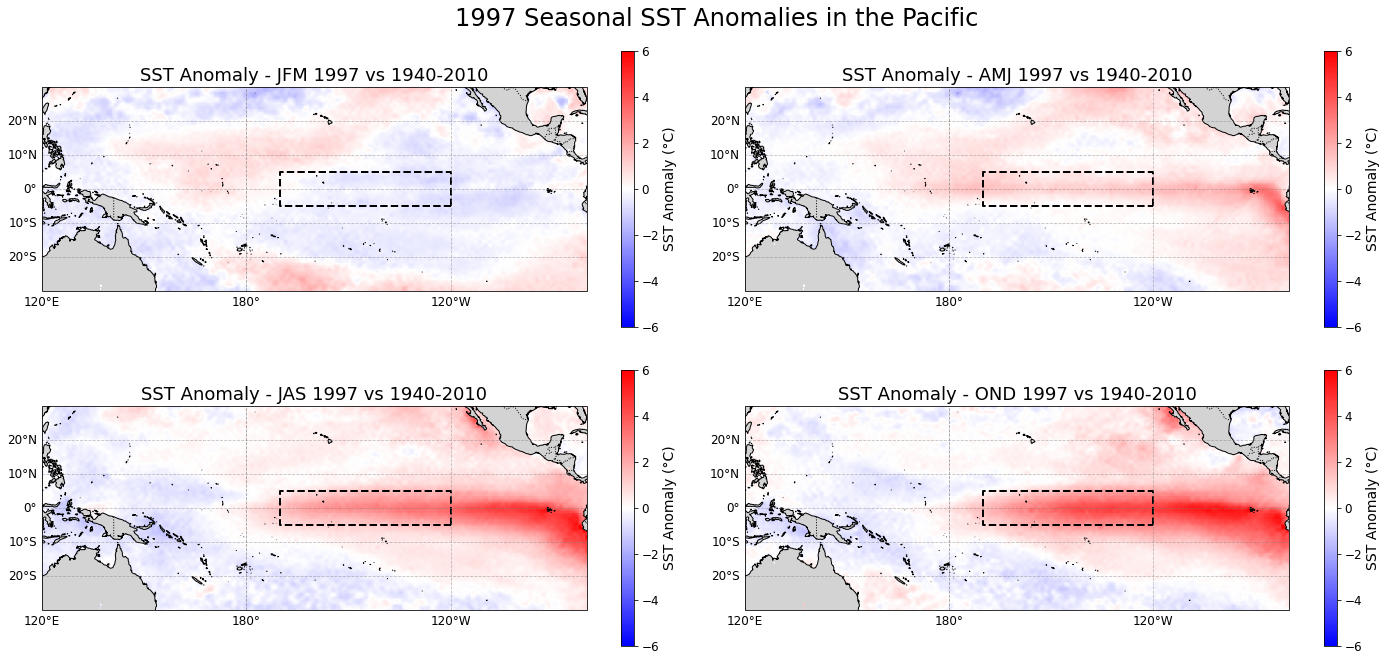

In [37]:
# Create 2x2 Subplots focused on the Pacific
projection = ccrs.PlateCarree(central_longitude=180)

fig, axs = plt.subplots(
    2, 2, figsize=(20, 10),
    subplot_kw={'projection': projection}
)

def plot_spatial(ax, data, title, cmap='bwr', cbar_label="SST Anomaly (°C)"):

    # Add Cartopy features: land, borders, and coastlines
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.coastlines(resolution='50m')

    ax.set_extent([120, 280, -30, 30], crs=ccrs.PlateCarree())

    # Plot data using pcolormesh (gridded data)
    mesh = ax.pcolormesh(
        data.longitude, data.latitude, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        vmin=-6, vmax=6
    )

    gl = ax.gridlines(
        draw_labels=True,
        linewidth=0.8, color='gray', alpha=0.5, linestyle='--'
    )

    # Label formatting
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label(cbar_label, fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # Titles
    ax.set_title(title, fontsize=18)
    ax.tick_params(axis='both', labelsize=12)
        # Define Nino 3.4 box boundaries
    lon_min, lon_max = 190, 240   # 170°W–120°W in 0–360° convention
    lat_min, lat_max = -5, 5

    # Create a rectangular polygon
    n34_box = box(lon_min, lat_min, lon_max, lat_max)

    # Add it to the map
    ax.add_geometries(
        [n34_box],
        crs=ccrs.PlateCarree(),
        facecolor="none",
        edgecolor="black",
        linewidth=2,
        linestyle="--"
    )

# Plot the data for each subplot
plot_spatial(axs[0, 0], JFM_anom['sst'], 'SST Anomaly - JFM 1997 vs 1940-2010')
plot_spatial(axs[0, 1], AMJ_anom['sst'], 'SST Anomaly - AMJ 1997 vs 1940-2010')
plot_spatial(axs[1, 0], JAS_anom['sst'], 'SST Anomaly - JAS 1997 vs 1940-2010')
plot_spatial(axs[1, 1], OND_anom['sst'], 'SST Anomaly - OND 1997 vs 1940-2010')

fig.suptitle("1997 Seasonal SST Anomalies in the Pacific", fontsize=24, y=0.95)

plt.tight_layout()
plt.show()

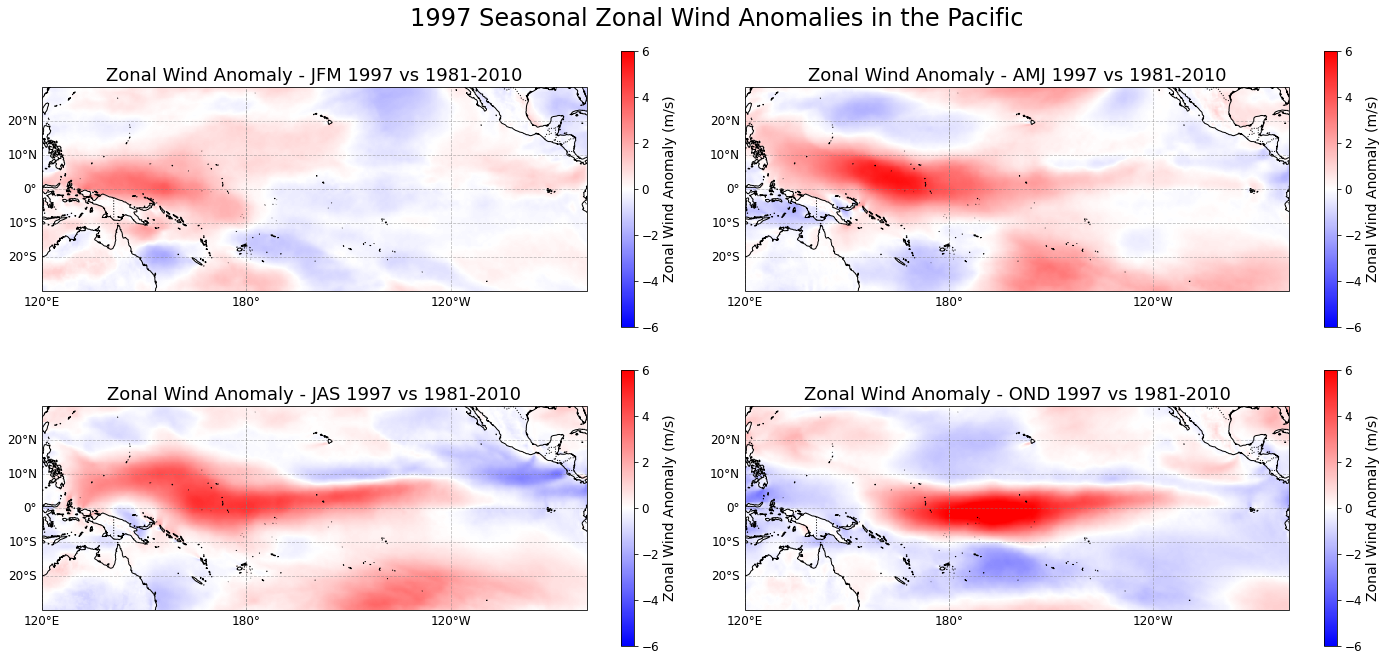

In [51]:
# Create 2x2 Subplots focused on the Pacific
projection = ccrs.PlateCarree(central_longitude=180)

fig, axs = plt.subplots(
    2, 2, figsize=(20, 10),
    subplot_kw={'projection': projection}
)

# Define a common plot styling function
def plot_spatial(ax, data, title, cmap='bwr', cbar_label="Zonal Wind Anomaly (m/s)"):

    # Add Cartopy features: land, borders, and coastlines
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.coastlines(resolution='50m')

    ax.set_extent([120, 280, -30, 30], crs=ccrs.PlateCarree())

    # Plot data using pcolormesh (gridded data)
    mesh = ax.pcolormesh(
        data.longitude, data.latitude, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        vmin=-6, vmax=6
    )

    gl = ax.gridlines(
        draw_labels=True,
        linewidth=0.8, color='gray', alpha=0.5, linestyle='--'
    )

    # Label formatting
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', shrink=0.8)
    cbar.set_label(cbar_label, fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # Titles
    ax.set_title(title, fontsize=18)

    ax.tick_params(axis='both', labelsize=12)

# Plot the data for each subplot
plot_spatial(axs[0, 0], JFM_anom['u10'], 'Zonal Wind Anomaly - JFM 1997 vs 1981-2010')
plot_spatial(axs[0, 1], AMJ_anom['u10'], 'Zonal Wind Anomaly - AMJ 1997 vs 1981-2010')
plot_spatial(axs[1, 0], JAS_anom['u10'], 'Zonal Wind Anomaly - JAS 1997 vs 1981-2010')
plot_spatial(axs[1, 1], OND_anom['u10'], 'Zonal Wind Anomaly - OND 1997 vs 1981-2010')

fig.suptitle("1997 Seasonal Zonal Wind Anomalies in the Pacific", fontsize=24, y=0.95)

plt.tight_layout()
plt.show()

---

The following code is supplementary, meant to highlight the intensity of the 1997 anomaly.
This uses the Niño 3.4 SST indices, which uses a 5-month running mean. This is the primary index used for monitoring ENSO.
More information is available at the [NCEI NOAA](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) website.

The code is a modified version of the code used from exercise 07, with slight modifications to use the current dataset.

In [47]:
n34_lat = slice(-5, 5)
n34_lon = slice(190, 240)

# 1. Climatology baseline (1981–2010)
sst_clim = data_pacific['sst'].mean()

# 2. Select 1997 SST
sst_1997 = data_pacific['sst'].sel(valid_time="1997")

# 3. Compute anomalies w.r.t monthly climatology
sst_anom = sst_1997 - sst_clim

# 4. Niño 3.4 region
sst_anom_n34 = data_pacific['sst'] - sst_clim

# 5. Spatial average
nino34 = sst_anom_n34.mean(dim=["latitude", "longitude"])

# 6. 5-month centered rolling mean (ONI)
nino34_smooth = nino34.rolling(valid_time=5, center=True).mean()
mean_base = nino34_smooth.mean()
std_base  = nino34_smooth.std()

nino34_std = (nino34_smooth - mean_base) / std_base

---

The plot below shows the anomaly within the climatological period. Highlighted in yellow is the year 1997, the focus of this exercise.

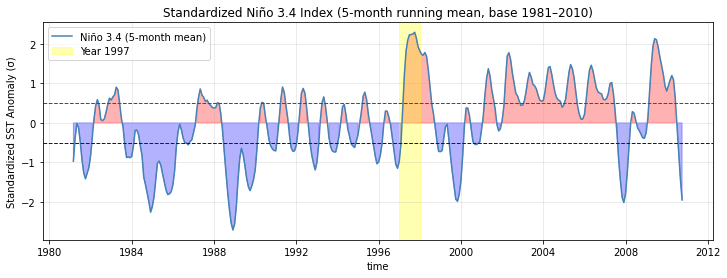

In [50]:
plt.figure(figsize=(12,4))
nino34_std.plot(color="steelblue", lw=1.5, label="Niño 3.4 (5-month mean)")
plt.axhline(0.5, color="r", ls="--", lw=1)
plt.axhline(-0.5, color="b", ls="--", lw=1)
plt.fill_between(nino34_std["valid_time"], 0, nino34_std,
                 where=nino34_std > 0, color="red", alpha=0.3)
plt.fill_between(nino34_std["valid_time"], 0, nino34_std,
                 where=nino34_std < 0, color="blue", alpha=0.3)
plt.axvspan("1997-01-01", "1997-12-30", color="yellow", alpha=0.3, label="Year 1997")
plt.title("Standardized Niño 3.4 Index (5-month running mean, base 1981–2010)")
plt.ylabel("Standardized SST Anomaly (σ)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Summary Report for Exercise 08

In normal conditions, easterlies prevail over the Pacifc Ocean. This is caused by the mid-latitude winds converging towards the Intertropical Convergence Zone. The ITCZ is generally found around the equatorial region, with variations caused by tilt of the Earth, or different seasons.

When we look at the spatial plot of the zonal wind anomaly for the year 1997, the Central Pacific is dominated by a positive wind anomaly, getting stronger as the year progresses. In other words, during those seasons, the winds have a more eastward magnitude when compared to the climatological mean. This means that either the trade winds are significantly weakened, or perhaps **<u>westerlies</u>** were present in this year, which was the case for 1997. 

The El Niño Southern Oscillation (ENSO) is a feedback mechanism caused by the interaction of Sea Surface Temperatures and atmospheric winds. What is interesting during the target period of this exercise is that the El Niño was particularly intense. We can see this when we look at the time series plot of the Niño 3.4 index, where the index reaches a value greater than 2 for almost the whole year. Not only that, the index showed a spike in the value, with the index starting from around 0 at the beginning of the year, reaching  peak values in just a few months. This means that the SST conditions in the Pacific rapidly intensified to exhibit El Niño conditions in a short timeframe.

This is related to the zonal wind anomaly observations that we have plotted before. The abnormal weakening of the trade winds/development of westerlies during the beginning of the year means that the building up of warm SSTs at the West Pacific continue to intensify. Note that the warm surface waters are usually pushed eastward by trade winds, resulting in upwelling, where colder water reaches the surface. In this case, the weak easterlies and/or westerlies both meant that warm SSTs are maintained in the East Pacific. This means that the intensity of the El Niño, and the rate at which it developed, is likely caused by the anomalous westerly winds. 

Moreover, 1997 El Niño event has multiple researches that support this finding, with one research by [Lengaigne, et. al](https://journals.ametsoc.org/view/journals/clim/16/20/1520-0442_2003_016_3330_tmwwea_2.0.co_2.xml) focused entirely on understanding the role of the 1997 westerly wind events (WWE) on the onset of the 1997 El Niño. The outputs of this exercise show this: the anomalous westerly winds during this year, and the very warm SSTs in the Central-East Pacific. The warm SSTs contributed to more westerlies because of surface convergence on the West Pacific, which encouraged warmer SSTs there, which encouraged more westerlies, and so on as the year progressed. However, the very same [research](https://journals.ametsoc.org/view/journals/clim/16/20/1520-0442_2003_016_3330_tmwwea_2.0.co_2.xml) did state that many models were not able to accurately predict the extremely steep rise in central and east Pacific SSTs. This was because the WWEs and their associated atmospheric models were not well simulated.

Despite this, the plots might have some innaccuracies. These errors come from the inherent nature of reanalysis data, where it is an assimilation of multiple data sources. This means that the best estimates over the Pacific might have errors with respect to magnitude. The seasonal averaging might lose some definition of the data as well, like what speicifc months westerly wind bursts were extreme. Albeit these caveats, this exercise was able to convey what happened during the 1997 El Niño event.

---

### AI Acknowledgement

The help of ChatGPT was utilized mainly for the assistance in the generation of plots.